# Electronics Overview

The electronics area provides a rich canvas for one piece flow production techniques.

Circuit analysis is often performed on graph based representations of a circuit which are easily modelled and then rendered as circuit diagrams or treated analytically.

This notebook demonstrates how we can use a range of techniques to script the creation of electrical circuit diagrams, as well as creating models of circuits that can be rendered as a schematic circuit diagram and analysed as a computational model. This means we can:

- create a model of a circuit as a computational object through a simple description language;
- render a schematic diagram of the circuit from the model;
- display analytic equations describing the model that represent particular quantities such as currents and voltages as a function of component variables;
- automatically calculate the values of voltages and currents from the model based on provided component values.

The resulting document is self-standing in terms of creating the media assets that are displayed from within the document itself. In addition, analytic treatments and exact calculations can be performed on the same model, which means that diagrams, analyses and calculations will always be consistent, automatically derived as they are from the same source. This compares to a traditional production route where the different components of the document may be created independently of each other.

## `lcapy`

As described elsewhere, [`lcapy`](https://github.com/mph-/lcapy) is a linear circuit analysis package that can be used to describe, display and analyse the behaviour of a wide range of linear analogue electrical circuits. `lcapy` supports numerical analysis of described circuits in terms of response in time and frequency domains, the charting of the results of the analysis and various forms of symbolic analysis of circuit descriptions in various domains.

`lcapy` use a circuit description that can be used to generate an circuit diagram as the basis for a wide range of analyses. For example, lcapy can be used to describe equivalent circuits (such as Thevenin or Norton equivalent circuits), or generate Bode plots.

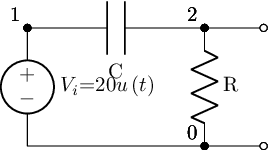

In [1]:
from lcapy import Circuit
 
# The things to the right of the semicolon on each line
# are the optional layout elements
# They are not *required* when defining the circuit
cct = Circuit()
cct.add("""
Vi 1 0_1 step 20; down
C 1 2; right, size=1.5
R 2 0; down
W 0_1 0; right
W 0 0_2; right, size=0.5
P1 2_2 0_2; down
W 2 2_2;right, size=0.5""")
 
cct.draw(style='american')

The `lcapy/schematic.py` package describes the various stylings and could be easily extended to support a named house style, or perhaps accommodate a regionalisation passed in as an explicit argument value:

```python
if style == 'american':
    style_args = 'american currents, american voltages'
elif style == 'british':
    style_args = 'american currents, european voltages'
elif style == 'european':
    style_args = ('european currents, european voltages, european inductors, european resistors')
```

As well as constructing circuits from netlist descriptions, we can also create them from network style descriptions:

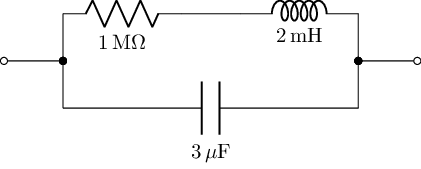

In [2]:
from lcapy import R, C, L
 
cct2 = (R(1e6) + L(2e-3)) | C(3e-6)

cct2.draw()

We can lookup a netlist description from the circuit object directly:

In [3]:
cct2.sch()

# Or as a string: cct2.netlist()

W 1 2; right=0.5
W 2 4; up=0.4
W 3 5; up=0.4
R1 4 6 1000000.0; right
W 6 7; right=0.5
L1 7 5 0.002; right
W 2 8; down=0.4
W 3 9; down=0.4
C1 8 9 3e-06; right
W 3 0; right=0.5

The diagrams generated from networks are open linear circuits rather than loops, which may not be quite what we want. But these circuits are quicker to write, so we can use them to draft netlists for us that we may then want to tidy up a bit further.

In [4]:
cct2.netlist()

'W 1 2; right=0.5\nW 2 4; up=0.4\nW 3 5; up=0.4\nR1 4 6 1000000.0; right\nW 6 7; right=0.5\nL1 7 5 0.002; right\nW 2 8; down=0.4\nW 3 9; down=0.4\nC1 8 9 3e-06; right\nW 3 0; right=0.5'

Circuit descriptions can also be loaded in from a named text file, which is handy for course material maintenance as well as reuse of circuits across materials: it’s easy enough to imagine a library of circuit descriptions

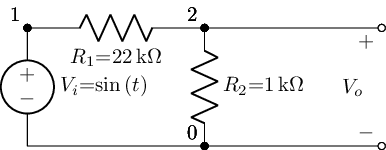

In [5]:
from lcapy import Circuit

# Create a file containing a circuit netlist
sch='''
Vi 1 0_1 {sin(t)}; down
R1 1 2 22e3; right, size=1.5
R2 2 0 1e3; down
P1 2_2 0_2; down, v=V_{o}
W 2 2_2; right, size=1.5
W 0_1 0; right
W 0 0_2; right
'''
 
fn="voltageDivider.sch"
with open(fn, "w") as text_file:
    text_file.write(sch)

# Create a circuit from a netlist file
cct = Circuit(fn)

cct.draw()

The ability to create – and share – circuit diagrams in a Python context that plays nicely with Jupyter notebooks is handy, but the `lcapy` approach becomes really useful if we want to produce other assets around the circuit we’ve just created.

For example, in the case of the above circuit, how do the various voltage levels across the resistors respond when we switch on the sinusoidal source?

In [6]:
import numpy as np

t = np.linspace(0, 5, 1000)
vr = cct.R2.v.evaluate(t)

Let's see what voltage response looks like:

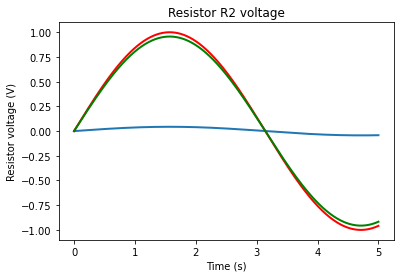

In [7]:
from matplotlib.pyplot import figure, savefig

fig = figure()
ax = fig.add_subplot(111, title='Resistor R2 voltage')

# The response voltage across R2
ax.plot(t, vr, linewidth=2)

# The input voltage, Vi
ax.plot(t, cct.Vi.v.evaluate(t), linewidth=2, color='red')

# The voltage aceoss R1
ax.plot(t, cct.R1.v.evaluate(t), linewidth=2, color='green')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Resistor voltage (V)');

Not the best example, admittedly, but you get the idea! Being a matplotlib chart, we can style it as we would any matplotlb chart. Or use a different plotting library altogether, such as `plotly`, to create interactive HTML charts.

Here’s another example, where I’ve created a simple interactive to let me see the effect of changing one of the component values on the response of a circuit to a step input:

In [8]:
from ipywidgets import interact

@interact(R=(1,10,1))
def response(R=1):
    cct = Circuit()

    cct.add('V 0_1 0 step 10;down')
    cct.add('L 0_1 0_2 1e-3;right')
    cct.add('C 0_2 1 1e-4;right')
    cct.add('R 1 0_4 {R};down'.format(R=R))
    cct.add('W 0_4 0; left')

    import numpy as np
    t = np.linspace(0, 0.01, 1000)
    vr = cct.R.v.evaluate(t)

    from matplotlib.pyplot import figure, savefig
    fig = figure()
    ax = fig.add_subplot(111, title='Resistor voltage (R={}$\Omega$)'.format(R))
    ax.plot(t, vr, linewidth=2)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Resistor voltage (V)')
    ax.grid(True)
    
    cct.draw()

interactive(children=(IntSlider(value=1, description='R', max=10, min=1), Output()), _dom_classes=('widget-int…

Using the network description of a circuit, it only takes a couple of lines to define a circuit and then get the transient response to step function for it:

In [9]:
from numpy import linspace

underDampedRLC = Vstep(10) + R(0.1) + L(0.2, 0)+ C(0.4, 0)
underDampedRLC.draw();

t = linspace(0, 10, 1000)

underDampedRLC.Isc.transient_response().plot(t);

NameError: name 'Vstep' is not defined

Or a frequncy response:

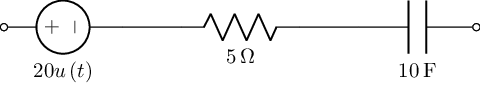

Should convert current expression to time-domain first


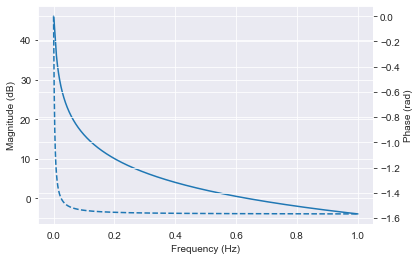

In [24]:
from numpy import logspace, linspace
from lcapy import Vstep, R, C, L

n = Vstep(20) + R(5) + C(10)
n.draw()

vf = linspace(0, 1, 4000)
n.Isc.frequency_response().plot(vf, log_scale=True);

It's trivial to make an end user application around a function that lets us select component values and explore the effect they have on the damping.

```{note}
This will only work interactively within a notebook or via a Thebe enabled code cell hooked up to a Jupyter kernel somewhere.
```

In [27]:
@interact(R1=(0.1, 10),L1=(0.01, 1),C1=(0.01,0.5))
def damping(R1=0.1,L1=0.2,C1=0.4):
    underDampedRLC = Vstep(10) + R(R1) + L(L1)+ C(C1)
    underDampedRLC.draw();

    t = linspace(0, 10, 1000)

    underDampedRLC.Isc.transient_response().plot(t);

interactive(children=(FloatSlider(value=0.1, description='R1', max=10.0, min=0.1), FloatSlider(value=0.2, desc…

As well as the numerical analysis, `lcapy` also supports a range of symbolic analysis functions. For example, consider a parallel resistor circuit, defined using a network description:

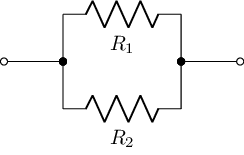

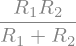

In [28]:
parallelR = R('R_1') | R('R_2')
parallelR.draw()


We can find the overall resistance in simplest terms:

In [ ]:
parallelR.simplify().R

```{note}
The ability to simplify expressions  – as in the example of the simplified expressions for overall capacitance or resistance in the parallel circuit examples above – directly from a circuit description whilst at the same time using that circuit description to render the circuit diagram, also reduces the amount of separation between those two outputs to zero – they are both generated from the self-same source item.
```

We can do a similar thing for parallel capacitors:

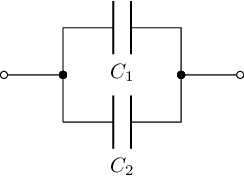

In [29]:
parallelC = C('C_1') | C('C_2')
parallelC.draw()

parallelC.simplify().C

We can fudge the creation of text around this representation:

In [35]:
from IPython.display import Latex

Latex(f"The overall resistance value simplifies to: {parallelR.simplify().R._repr_latex_()}")

<IPython.core.display.Latex object>

Some other elementary transformations we can apply – providing expressions for the an input voltage in the time or Laplace/s domain:

In [30]:
from lcapy import Vac, t, s, pi

#Representation of AC voltage source in time domain
#Vac(amplitude, phase)
Vac(20, pi/2).Voc(t)

We also have access to the s domain:

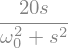

In [31]:
#Representation of AC voltage source in s domain
Vac(20).Voc(s)

Pole-zero plots can be created quite straightforwardly, directly from an expression in the s-domain:

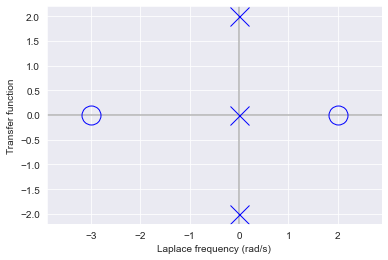

In [39]:
#pole-zero plot
from lcapy import s, j, transfer
from matplotlib.pyplot import savefig, show

H_ = transfer((s - 2) * (s + 3) / (s * (s - 2 * j) * (s + 2 * j)))
H_.plot();

When trying to plot things like pole zero charts, where it is important that the chart matches a particular s-domain expression, we can guarantee that the chart is correct by deriving it directly from the s-domain expression, and then rendering that expression in pretty LaTeX equation form in the materials.